# **Importing Dependacies:**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL

#DL libraries
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop



# **Data Preprocessing:**

## **Loading Dataset:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip  '/content/drive/MyDrive/archive.zip'  -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/validation/fear/8797.jpg  
  inflating: /content/images/validation/fear/8818.jpg  
  inflating: /content/images/validation/fear/886.jpg  
  inflating: /content/images/validation/fear/9037.jpg  
  inflating: /content/images/validation/fear/9040.jpg  
  inflating: /content/images/validation/fear/9101.jpg  
  inflating: /content/images/validation/fear/911.jpg  
  inflating: /content/images/validation/fear/9179.jpg  
  inflating: /content/images/validation/fear/9205.jpg  
  inflating: /content/images/validation/fear/9232.jpg  
  inflating: /content/images/validation/fear/9251.jpg  
  inflating: /content/images/validation/fear/9261.jpg  
  inflating: /content/images/validation/fear/9281.jpg  
  inflating: /content/images/validation/fear/9302.jpg  
  inflating: /content/images/validation/fear/9333.jpg  
  inflating: /content/images/validation/fear/9369.jpg  
  inflating: /content/images/validation/fear/9370.jpg  

In [ ]:
#Data Augmentation code
#datagen = ImageDataGenerator(
#    rotation_range = False,
#    width_shift_range = 0.2,
#    shear_range = 0.2,
#    zoom_range = 0.2,
#    horizontal_flip = True,
#    fill_mode = 'nearest'
#)


#def augmentation():


#img = load_img('/content/drive/MyDrive/images/train/disgust/299.jpg')
#x = img_to_array(img)
#x = x.reshape((1,) + x.shape)


#i = 0
#for batch in datagen.flow(x, batch_size = 1,
#                       save_to_dir = 'preview', save_prefix = 'd', save_format = 'jpg') :
#  i+=1
#  if i>10:
#    break


#augmentation()

In [ ]:
#Normalizing and creating train, test data
train_directory = '/content/images/train/'
test_directory = '/content/images/validation/'
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [ ]:

batch_size = 64
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    #subset = "training",
    seed = 123,
    label_mode = "categorical",
    image_size = (224,224),
    batch_size = batch_size
)

train_ds = train_ds.map(process)


Found 28821 files belonging to 7 classes.


In [ ]:
batch_size = 64
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    #subset = "training",
    seed = 123,
    label_mode = "categorical",
    image_size = (224,224),
    batch_size = batch_size
)

val_ds = val_ds.map(process)


Found 7066 files belonging to 7 classes.


## **Image Augmentation:**

In [ ]:
# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest') #can try reflect, ('constant', cval = 125) for grey pixels

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_directory,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        test_directory,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')







Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
## Code for augmenting each image for every category in training folder
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest') #can try reflect, ('constant', cval = 125) for grey pixels


h_d =  '/content/images/train/happy/'
i = 0
for batch in datagen.flow_from_directory(directory = h_d,
                                         target_size = (224,224),
                                         batch_size = 32,
                                         #color_mode='rgb',
                                         save_to_dir = h_d,
                                         save_prefix = 'aug',
                                         save_format = 'jpg',
                                         class_mode='categorical'):

 i+=1
 if i>35000:
   break


train_generator = datagen.flow_from_directory(
        train_directory,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')


Found 0 images belonging to 0 classes.
Found 28821 images belonging to 7 classes.


# **Creating models using Transfer Learning:**

## **MobileNetV2:**

In [ ]:
mobilenetv2_model = Sequential()
pretrained_model = tf.keras.applications.MobileNetV2(
    include_top=False,

    weights= None,
    #input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=7,
    classifier_activation="softmax",
)

l = 0
for layer in pretrained_model.layers :
  if l<=53:
    layer.trainable = True
  l+=1

In [ ]:
mobilenetv2_model.add(pretrained_model)
mobilenetv2_model.add(Flatten())
mobilenetv2_model.add(Dense(512, activation = 'relu'))
mobilenetv2_model.add(Dropout(0.25))
mobilenetv2_model.add(Dense(256, activation = 'relu'))
mobilenetv2_model.add(Dropout(0.25))
mobilenetv2_model.add(Dense(128, activation = 'relu'))
mobilenetv2_model.add(Dropout(0.25))
mobilenetv2_model.add(Dense(7, activation = 'softmax'))

In [ ]:
mobilenetv2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               655872    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                      

In [ ]:
mobilenetv2_model.compile(optimizer = Adam(lr=0.0005), loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks  import EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("/content/drive/MyDrive/mobilenetv2_model.h5", monitor = 'val_accuracy', verbose =1, save_best_only = True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.5,
                               patience = 3,
                               verbose = 1,
                               min_delta = 0.0001)

callbacks_list = [checkpoint, reduce_learningrate]

epochs = 20

In [ ]:
history = mobilenetv2_model.fit(
    train_generator,
    validation_data=validation_generator,
    #train_ds,
    #validation_data = val_ds,
    epochs = epochs,
    callbacks=callbacks_list
)


### **Plotting the model accuracy and model loss:**

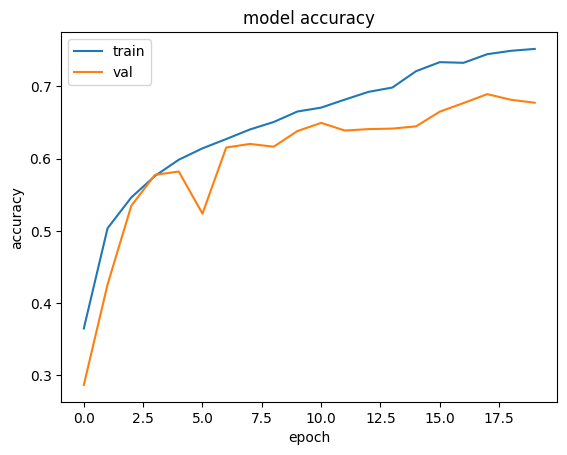

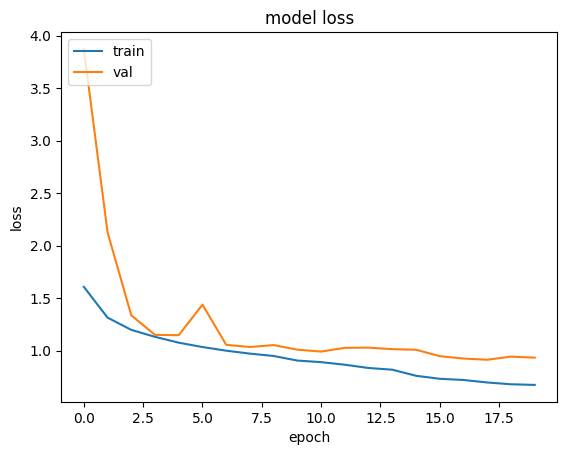

In [ ]:
#Accuracy Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **ResNet50V2:**

In [ ]:
resnetv2_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50V2(
    include_top=False,

    weights="imagenet",
    #input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=7,
    classifier_activation="softmax",
)

for layer in pretrained_model.layers :
  layer.trainable = False


resnetv2_model.add(pretrained_model)
resnetv2_model.add(Flatten())
resnetv2_model.add(Dense(512, activation = 'relu'))
resnetv2_model.add(Dropout(0.20))
resnetv2_model.add(Dense(256, activation = 'relu'))
resnetv2_model.add(Dropout(0.20))
resnetv2_model.add(Dense(128, activation = 'relu'))
resnetv2_model.add(Dropout(0.20))
resnetv2_model.add(Dense(7, activation = 'softmax'))

In [ ]:
resnetv2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)              

In [ ]:
resnetv2_model.compile(optimizer = Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks  import EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("/content/drive/MyDrive/resnetv2_model.h5", monitor = 'val_accuracy', verbose =1, save_best_only = True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.5,
                               patience = 3,
                               verbose = 1,
                               min_delta = 0.0001)

callbacks_list = [checkpoint, reduce_learningrate]

epochs = 20

In [ ]:
history = resnetv2_model.fit(
    train_generator,
    validation_data=validation_generator,
    #train_ds,
    #validation_data = val_ds,
    epochs = epochs,
    callbacks=callbacks_list
)


### **Plotting model accuracy and model loss:**

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **MobileNetV3Large:**

In [ ]:
mobilenetv3large_model = Sequential()


pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    #alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    #input_tensor=None,
    classes=7,
    pooling= 'avg',
    #dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
)


#for layer in pretrained_model.layers :
#  layer.trainable = False


mobilenetv3large_model.add(pretrained_model)
mobilenetv3large_model.add(Flatten())
mobilenetv3large_model.add(Dense(512, activation = 'relu'))
mobilenetv3large_model.add(Dropout(0.25))
mobilenetv3large_model.add(Dense(256, activation = 'relu'))
mobilenetv3large_model.add(Dropout(0.25))
mobilenetv3large_model.add(Dense(128, activation = 'relu'))
mobilenetv3large_model.add(Dropout(0.25))
mobilenetv3large_model.add(Dense(7, activation = 'softmax'))

In [ ]:
mobilenetv3large_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 flatten_4 (Flatten)         (None, 960)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               492032    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                      

In [ ]:
mobilenetv3large_model.compile(optimizer = Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks  import EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("/content/drive/MyDrive/MobileNetV3Large_model.h5", monitor = 'val_accuracy', verbose =1, save_best_only = True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.5,
                               patience = 3,
                               verbose = 1,
                               min_delta = 0.0001)

callbacks_list = [checkpoint, reduce_learningrate]

epochs = 25

In [ ]:
history = mobilenetv3large_model.fit(
    train_generator,
    validation_data=validation_generator,
    #train_ds,
    #validation_data = val_ds,
    epochs = epochs,
    callbacks=callbacks_list
)


Epoch 1/25
451/451 [==============================] - ETA: 0s - loss: 1.4821 - accuracy: 0.4257
Epoch 1: val_accuracy improved from -inf to 0.17337, saving model to /content/drive/MyDrive/MobileNetV3Large_model.h5
451/451 [==============================] - 441s 962ms/step - loss: 1.4821 - accuracy: 0.4257 - val_loss: 2.1101 - val_accuracy: 0.1734 - lr: 1.0000e-04
Epoch 2/25
451/451 [==============================] - ETA: 0s - loss: 1.3403 - accuracy: 0.4893
Epoch 2: val_accuracy improved from 0.17337 to 0.23380, saving model to /content/drive/MyDrive/MobileNetV3Large_model.h5
451/451 [==============================] - 427s 948ms/step - loss: 1.3403 - accuracy: 0.4893 - val_loss: 2.0476 - val_accuracy: 0.2338 - lr: 1.0000e-04
Epoch 3/25
451/451 [==============================] - ETA: 0s - loss: 1.2438 - accuracy: 0.5320
Epoch 3: val_accuracy improved from 0.23380 to 0.32876, saving model to /content/drive/MyDrive/MobileNetV3Large_model.h5
451/451 [==============================] - 430s 

### **Plotting the model accuracy and model loss:**

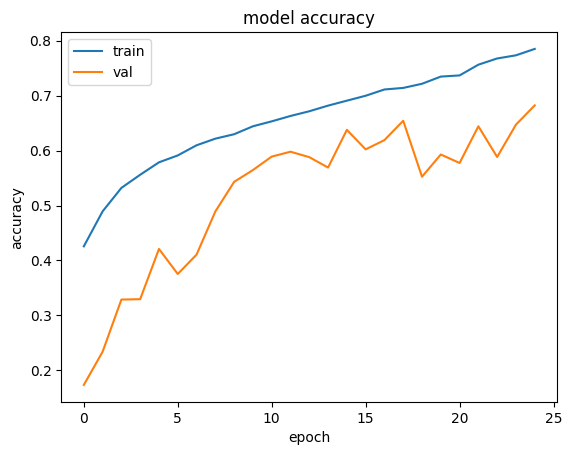

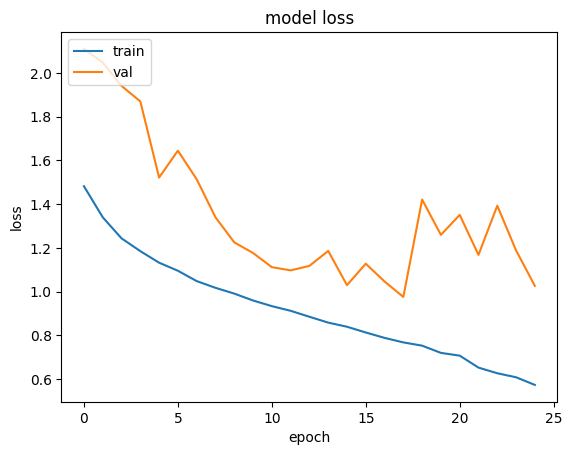

In [ ]:
#Accuracy Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **EfficientNetV2B2:**

In [ ]:
efficientnetv2b2 = Sequential()


pretrained_model = tf.keras.applications.EfficientNetV2B2(
    include_top=False,
    weights="imagenet",
    #input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=7,
    classifier_activation="softmax"

)

#for layer in pretrained_model.layers :
#  layer.trainable = False

#l = 0
#for layer in pretrained_model.layers :
#  if l<=53:
#    layer.trainable = True
#  l+=1

#from tensorflow.keras import regularizers

efficientnetv2b2.add(pretrained_model)
efficientnetv2b2.add(Flatten())
efficientnetv2b2.add(Dense(512, activation = 'relu'))
efficientnetv2b2.add(Dropout(0.5))
efficientnetv2b2.add(Dense(256, activation = 'relu'))
efficientnetv2b2.add(Dropout(0.5))
efficientnetv2b2.add(Dense(128, activation = 'relu'))
efficientnetv2b2.add(Dropout(0.5))
efficientnetv2b2.add(Dense(64, activation = 'relu'))
efficientnetv2b2.add(Dropout(0.5))
efficientnetv2b2.add(Dense(7, activation = 'softmax'))



In [ ]:
efficientnetv2b2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 1408)             8769374   
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1408)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               721408    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
efficientnetv2b2.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks  import EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("/content/drive/MyDrive/efficientnetv2b2.h5", monitor = 'val_accuracy', verbose =1, save_best_only = True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.5,
                               patience = 3,
                               verbose = 1,
                               min_delta = 0.0001)

callbacks_list = [checkpoint, reduce_learningrate]

epochs = 25

In [ ]:
history = efficientnetv2b2.fit(
    train_generator,
    validation_data=validation_generator,
    #train_ds,
    #validation_data = val_ds,
    epochs = epochs,
    callbacks=callbacks_list
)


### **Plotting model accuracy and model loss:**

In [ ]:
#Accuracy Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Inception v4:**